In [96]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA
import gc

In [2]:
RAD_DIRECTORY = 'data/ORB/'
SIZE_DIRECTORY = 'data/ORB/'
MIN_YEAR = 2004
MAX_YEAR = 2020
MIN_TEST_YEAR = 2020

In [3]:
def list_orb_files(file_dir, basin, orb_suffix, min_year, max_year):
    years = [str(i) for i in range(min_year, max_year + 1)]
    files = os.listdir(file_dir)
    rad_files = []
    for f in files:
        if f[4:8] in years:
            if f.startswith(basin):
                if (f[-len(orb_suffix):] == orb_suffix):
                    rad_files.append(f)
        
    return rad_files

In [4]:
rad_files = list_orb_files(RAD_DIRECTORY, 'AL', '-rad.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)

In [77]:
# Radius: ~ 6s runtime
dfs = []
rad_cols = [str(i) for i in range(5, 600 + 5, 5)]
for f in rad_files:
    path = RAD_DIRECTORY + f
    storm_id = f.split('-')[0]
    df = pd.read_csv(path)
    df['time'] = pd.to_datetime(df['time']).dt.round('min')
    cols = ['time']
    cols.extend(rad_cols)
    df.columns = cols
    df['ID'] = storm_id
    dfs.append(df)
df_rad = pd.concat(dfs)
df_rad.sort_values(by = ['ID', 'time'], inplace=True, ignore_index=True)

In [83]:
del dfs
gc.collect()

3582

In [78]:
# Get rid of rows with nans
df_rad_clean = df_rad.loc[df_rad.isnull().sum(axis = 1) == 0].copy()

In [79]:
pca_rad = PCA(n_components=3)
X_rad = df_rad_clean.loc[df_rad_clean.time.dt.year < MIN_TEST_YEAR, rad_cols]
X_rad_centered = X_rad - X_rad.mean(axis = 0)
pca_rad.fit(X_rad_centered)
pca_rad_applied = pca_rad.transform(df_rad_clean.loc[:, rad_cols] - X_rad.mean(axis = 0))
df_rad_clean[['rad_pc_1', 'rad_pc_2', 'rad_pc_3']] = pca_rad_applied

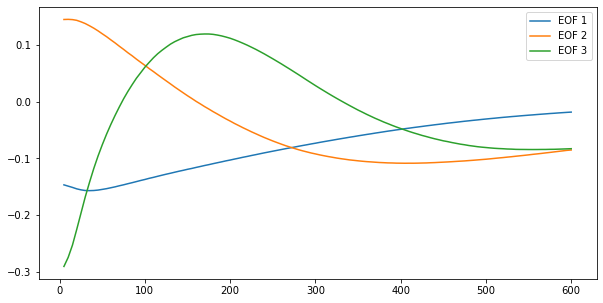

In [80]:
x_rad = np.array(rad_cols, dtype = 'int')
plt.figure(figsize = (10, 5))
for i in range(3):  
    plt.plot(x_rad, pca_rad.components_[i,:], label = f'EOF {i + 1}')

plt.legend()
plt.show()

In [81]:
df_rad.loc[df_rad.isnull().sum(axis = 1) == 0, ['rad_pc_1', 'rad_pc_2', 'rad_pc_3']] = pca_rad_applied

In [179]:
data = df_rad.drop(columns = rad_cols)

In [180]:
data.head()

,time,ID,rad_pc_1,rad_pc_2,rad_pc_3
0,2004-07-31 18:00:00,AL012004,-84.852469,-13.727752,-6.989022
1,2004-07-31 18:30:00,AL012004,-75.468454,-13.450455,-3.159751
2,2004-07-31 19:00:00,AL012004,-72.912953,-10.025802,-3.654504
3,2004-07-31 19:30:00,AL012004,-68.151672,-4.937895,2.328174
4,2004-07-31 20:00:00,AL012004,-66.796416,-4.465255,11.307172


Get differenced PC components for fitting VAR model

In [181]:
ids = pd.unique(data['ID'])
target_cols = ['rad_pc_'+ x for x in ['1', '2', '3']]
result_cols = ['delta_pc_'+ x for x in ['1', '2', '3']]

In [182]:
for id in ids:
    data.loc[data['ID'] == id, result_cols] = data.loc[data['ID'] == id, target_cols].diff().to_numpy()

In [183]:
data.head()

,time,ID,rad_pc_1,rad_pc_2,rad_pc_3,delta_pc_1,delta_pc_2,delta_pc_3
0,2004-07-31 18:00:00,AL012004,-84.852469,-13.727752,-6.989022,NaN,NaN,NaN
1,2004-07-31 18:30:00,AL012004,-75.468454,-13.450455,-3.159751,9.384015,0.277297,3.829271
2,2004-07-31 19:00:00,AL012004,-72.912953,-10.025802,-3.654504,2.555501,3.424653,-0.494754
3,2004-07-31 19:30:00,AL012004,-68.151672,-4.937895,2.328174,4.761281,5.087906,5.982678
4,2004-07-31 20:00:00,AL012004,-66.796416,-4.465255,11.307172,1.355256,0.472640,8.978998


In [184]:
del target_cols, result_cols

In [ ]:
#TODO: TEST ACTUAL COEFFICIENTS FOR STATIONARITY??

Set up regression matices for VAR model

In [201]:
lags = [1, 2, 3, 4, 5, 6]
target_cols = ['delta_pc_'+ x for x in ['1', '2', '3']]

In [202]:
# Time to run: ~ 25 s
# Get lagged values
for lag in lags:
    result_cols = ['delta_pc_'+ x + '-' + str(lag) for x in ['1', '2', '3']]
    for id in ids:
        temp = data.loc[data['ID'] == id, target_cols]
        data.loc[data['ID'] == id, result_cols] = temp.shift(lag).to_numpy()

In [93]:
data.head()

,time,ID,rad_pc_1,rad_pc_2,rad_pc_3,delta_pc_1,delta_pc_2,delta_pc_3,delta_pc_1-1,delta_pc_2-1,...,delta_pc_3-3,delta_pc_1-4,delta_pc_2-4,delta_pc_3-4,delta_pc_1-5,delta_pc_2-5,delta_pc_3-5,delta_pc_1-6,delta_pc_2-6,delta_pc_3-6
0,2004-07-31 18:00:00,AL012004,-84.852469,-13.727752,-6.989022,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-07-31 18:30:00,AL012004,-75.468454,-13.450455,-3.159751,9.384015,0.277297,3.829271,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-07-31 19:00:00,AL012004,-72.912953,-10.025802,-3.654504,2.555501,3.424653,-0.494754,9.384015,0.277297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-07-31 19:30:00,AL012004,-68.151672,-4.937895,2.328174,4.761281,5.087906,5.982678,2.555501,3.424653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-07-31 20:00:00,AL012004,-66.796416,-4.465255,11.307172,1.355256,0.472640,8.978998,4.761281,5.087906,...,3.829271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
# Set VAR parameters (make a function out of all this)
# p in {1, 2, 3, 4, 5, 6}
# k in {1, 2, 3}
# Have checked this against built-in python methods and it gives the correct estimates

def vectorAR(data, p, k):
    lags = [str(x) for x in range(1, p+1)]
    pcs = [str(x) for x in range(1, k+1)]

    # Columns to be used for Y - k x n matrix
    Y_cols = ['delta_pc_' + x for x in pcs]

    # Columns to be used for Z - kp x n matrix
    Z_cols = [x + '-' + y for y, x in itertools.product(lags, Y_cols)]
    all_cols = Y_cols + Z_cols
    
    # Get columns needed for regression
    data_sliced = data[all_cols].copy()
    data_sliced.dropna(inplace=True) # Get rid of any missigness.

    # Construct Y and Z for regression
    Y = data_sliced[Y_cols].to_numpy().T
    Z = data_sliced[Z_cols].to_numpy().T
    n = Y.shape[1]

    # Do regression. See: https://en.wikipedia.org/wiki/Vector_autoregression#Estimation
    # and "Time series analysis and applications" text for details
    ZZT = Z @ Z.T
    ZZTinv = np.linalg.inv(ZZT)
    YZT = Y @ Z.T
    B = YZT @ ZZTinv
    coef_est = np.array(np.split(B, p, axis = 1))

    resid = Y - B @ Z
    sigma_est = (resid @ resid.T)/n

    def correlation_from_covariance(covariance):
        v = np.sqrt(np.diag(covariance))
        outer_v = np.outer(v, v)
        correlation = covariance / outer_v
        correlation[covariance == 0] = 0
        return correlation

    corr_est = correlation_from_covariance(sigma_est)

    return [coef_est, sigma_est, corr_est, n]

Do BIC for model selection of model order.

In [196]:
def BIC(sigma_est, k, p, n):
    return np.log(np.linalg.det(sigma_est)) + (k**2)*p*np.log(n)/n

In [205]:
for p in [1, 2, 3, 4, 5, 6]:
    coef_est, sigma_est, corr_est, n = vectorAR(data, p, 3)
    bic = BIC(sigma_est, 3, p, n)
    print(f'p = {p} \n--------------')
    print(f'n: {n}')
    print(f'BIC: {bic}')
    print('\n')


p = 1 
--------------
n: 101888
BIC: 13.87154225840301


p = 2 
--------------
n: 101390
BIC: 13.749841015333471


p = 3 
--------------
n: 100895
BIC: 13.744122366573409


p = 4 
--------------
n: 100404
BIC: 13.733636145635272


p = 5 
--------------
n: 99923
BIC: 13.726062009788954


p = 6 
--------------
n: 99443
BIC: 13.724047584593535




In [262]:
coef_est, sigma_est, corr_est, n = vectorAR(data, 2, 2)
coef_est

array([[[-0.0183735 , -0.65644809],
        [-0.34968365,  0.17331294]],

       [[ 0.0135909 , -0.18472904],
        [-0.03501105, -0.0318501 ]]])

In [ ]:
# Define your own VAR class that can simulate from scratch, or simulate given a starting sequence of data (pc differences)

# Make plots of pc1 and pc2 evolving in pc space over the course of a storm for both simulated and real data

# Get simualtions going to check for validity. MAYBE get simulations going to check for power. 

In [325]:
class VarProcess:
    def __init__(self, coefs, sigma):
        """
        Parameters:
            - coefs (np.ndarray): p x k x k array holding coefficients for the VAR model.
            - sigma (np.ndarray): k x k covariance matrix for gaussian noise on the VAR model.
        """
        self.coefs = coefs
        self.sigma = sigma
        self.p = coefs.shape[0]
        self.k = coefs.shape[1]
        
        assert coefs.shape[1] == coefs.shape[2], 'coefs has improper dimensions.'


    def generate_sample(self, nsample=100, burnin=100, starters=None):
        """
        Generate a simulated sample from the VAR model, with or without a starter sequence

        Parameters:
        - nsample (int):
        - burnin (int): If starters == None, how many data points at beginning of
            simulation to throw out?
        - starters (np.ndarray): If None, generate unconcitionally. Otherwise, 
            an n x k ndarray of observations to start off the party. Must be the
            case that n >= p
        - f (function): Takes starters as an argument, 
        """

        # Initialize with zeros if no starters provided
        if starters is None:
            starters = np.zeros((self.p, self.k))
            nstarters = self.p
            nsim = nsample + burnin 
        else:
            nstarters = starters.shape[0]
            assert nstarters >= self.p, 'Must provide at least p observations in starters.'
            nsim = nsample
            burnin = 0
        
        # Simulate errors
        W =  np.random.multivariate_normal(np.zeros(self.k), self.sigma, size=nsim)
        
        # Simulate process
        Y = np.zeros((nsim, self.k))
        Y[:nstarters,:] = starters
        
        for t in range(nstarters, nsim):
            Y[t] = W[t]
            for i in range(1, self.p+1):
                Y[t] += self.coefs[i-1] @ Y[t-i]
        
        Y = Y[burnin:]
        
        return Y

In [332]:
start = np.array([[1, 2], [3, 4]])
fake_coef = np.array([[[0.5, -0.25], [-0.25, 0.5]], [[-0.2, 0.1], [0.1, -0.2]]])
fake_sig = np.eye(2)

In [340]:
a = VarProcess(fake_coef, fake_sig)
Y = a.generate_sample(nsample = 10000, starters = start, burnin=100)

In [343]:
Y

array([[ 1.00000000e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00],
       [ 1.48722888e+00,  2.22501541e+00],
       ...,
       [ 2.54342300e-01,  1.64318888e+00],
       [-8.98633352e-01, -2.98855689e-03],
       [-3.79542314e-01,  1.71007163e-01]])

In [344]:
var_model = VAR(Y)
vm_fit = var_model.fit(2)
vm_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Mar, 2022
Time:                     22:32:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                -0.00470152
Nobs:                     9998.00    HQIC:               -0.00947201
Log likelihood:          -28303.5    FPE:                   0.988158
AIC:                   -0.0119131    Det(Omega_mle):        0.987170
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.004334         0.010018           -0.433           0.665
L1.y1         0.493158         0.009736           50.655           0.000
L1.y2        -0.252882         0.009882          -25.590           0.000
L2.y1        -0.197542

In [336]:
from statsmodels.tsa.api import VAR

In [166]:
q = data.loc[data['ID'] == 'AL062010', ['delta_pc_'+x for x in ['1', '2', '3']]].dropna().reset_index(drop = True)

In [167]:
var_model = VAR(q)
vm_fit = var_model.fit(2)
vm_fit.summary()

In [178]:
coef_est, corr_est

([array([[ 0.44512357, -0.00733287,  0.16004283],
         [ 0.04841022,  0.63731111, -0.06472015],
         [ 0.0443343 ,  0.0503207 ,  0.60633131]]),
  array([[ 0.00624555, -0.120006  , -0.21284595],
         [ 0.05791643,  0.07503895,  0.04895411],
         [-0.05670574,  0.08186106, -0.09490859]])],
 array([[ 1.        , -0.46481252,  0.24944005],
        [-0.46481252,  1.        , -0.47676434],
        [ 0.24944005, -0.47676434,  1.        ]]))

In [66]:
tst_to_model.diff().to_csv('data/testing_var_fit.csv', index=False)

In [345]:
import sequentialGOF as gof

In [ ]:
class DataConstructor:
    def __init__(self, real_data, generative_mod, ntrain, neval, mtrain, meval, L, J, null_hyp = False):
        assert ntrain + neval <= len(real_data), f"ntrain + neval = {ntrain + neval}, len(real_data) = {len(real_data)}."

        train_data = real_data.iloc[:ntrain]
        test_data = real_data.iloc[ntrain:(ntrain+neval)].reset_index(drop = True)     

        cols = list(real_data.columns)
        self.seq_cols = cols

        def get_generated(row, m, add_label = True):
            S = row.to_numpy()
            A = S[:J]
            
            # If generating under the null, create list of all generated sequences, 
            # otherwise, use the real sequence as the first element of the list
            if null_hyp:
                seq_list = []
                m_rep = m + 1
            else:
                seq_list = [S]
                m_rep = m

            for jj in range(m_rep):
                seq_list.append(generative_mod.generate_sample_custom(nsample = L - J, starters = A))
            df = pd.DataFrame(seq_list, columns = cols)
            
            if add_label:
                labs = np.zeros(m+1, dtype = int)
                labs[0] = 1
                df['Y'] = labs
            
            return df

        # Construct training set
        T_list = []
        for row in train_data.iterrows():
            T_list.append(get_generated(row[1], mtrain))
        T = pd.concat(T_list, ignore_index = True)
        self.training = T

        # Construct evaluation set
        if neval > 0:
            V_list = []
            for row in test_data.iterrows():
                V_list.append(get_generated(row[1], meval))
            V = pd.concat(V_list, ignore_index = True)
            self.evaluation = V
        else:
            self.evaluation = None